In [0]:
!pip install -q tensorflow-gpu==2.0.0

In [1]:
import tensorflow as tf
import itertools
import warnings 

warnings.filterwarnings('ignore')
print(tf.__version__)

2.2.0-rc3


In [2]:
print("GPU Availabe:", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Availabe: True


In [3]:
if tf.test.is_gpu_available():
  device_name = tf.test.gpu_device_name()
else:
  device_name = '/CPU:0'
print(device_name)

/device:GPU:0


In [0]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [0]:
## define a function for the generator
def make_generator_network(
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=784):
  
  model = tf.keras.Sequential()
  for i in range(num_hidden_layers):
    model.add(
        tf.keras.layers.Dense(
            units=num_hidden_units, use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
  
  model.add(tf.keras.layers.Dense(units=num_output_units, activation='tanh'))
  return model

## define a function for the discriminator
def make_discriminator_network(
      num_hidden_layers=1, 
      num_hidden_units=100, 
      num_output_units=1):
  
  model = tf.keras.Sequential()
  for i in range(num_hidden_layers):
    model.add(tf.keras.layers.Dense(
        units=num_hidden_units))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(rate=0.5))
  
  model.add(
      tf.keras.layers.Dense(units=num_output_units, activation=None))
  return model



In [0]:
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

In [0]:
tf.random.set_seed(1)

In [8]:
gen_model = make_generator_network(
    num_hidden_layers = gen_hidden_layers,
    num_hidden_units = gen_hidden_size,
    num_output_units = np.prod(image_size))

gen_model.build(input_shape=(None, z_size))
gen_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  2000      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  79184     
Total params: 81,184
Trainable params: 81,184
Non-trainable params: 0
_________________________________________________________________


In [9]:
disc_model = make_discriminator_network(
    num_hidden_layers = disc_hidden_layers,
    num_hidden_units = disc_hidden_size)

disc_model.build(input_shape=(None, np.prod(image_size)))
disc_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  78500     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  101       
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


In [10]:
## Defining the training dataset
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [0]:
def preprocess(ex, mode='uniform'):
  image = ex['image']
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.reshape(image, [-1])
  image = image*2-1.0
  if mode == 'uniform':
    input_z = tf.random.uniform(
        shape=(z_size,), minval=-1.0, maxval=1.0)
  elif mode == 'normal':
    input_z = tf.random_normal(shape=(z_size,))
  
  return input_z, image

mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)


In [12]:
mnist_trainset = mnist_trainset.batch(32, drop_remainder=True)
input_z, input_real = next(iter(mnist_trainset))
print('input-z -- shape: ', input_z.shape)
print('input-real -- shape: ', input_real.shape)

input-z -- shape:  (32, 20)
input-real -- shape:  (32, 784)


In [13]:
g_output = gen_model(input_z)
print('Output of G -- shape: ', g_output.shape)

Output of G -- shape:  (32, 784)


In [14]:
d_logits_real = disc_model(input_real)
d_logits_fake = disc_model(g_output)
print('Disc. (real) -- shape: ', d_logits_real.shape)
print('Disc. (fake) -- shape: ', d_logits_fake.shape)

Disc. (real) -- shape:  (32, 1)
Disc. (fake) -- shape:  (32, 1)


In [15]:
## Training the GAN model
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Loss for the generator
g_labels_real = tf.ones_like(d_logits_fake)
g_loss = loss_fn(y_true=g_labels_real, y_pred=d_logits_fake)
print('Generator Loss: {:.4f}'.format(g_loss))

## Loss for the discriminator
d_labels_real = tf.ones_like(d_logits_real)
d_labels_fake = tf.zeros_like(d_logits_fake)

d_loss_real = loss_fn(y_true=d_labels_real, y_pred=d_logits_real)
d_loss_fake = loss_fn(y_true=d_labels_fake, y_pred=d_logits_fake)
print('Discriminator Losses: Real {:.4f} Fake {:.4f}'.format(d_loss_real.numpy(), d_loss_fake.numpy()))


Generator Loss: 0.7355
Discriminator Losses: Real 1.5073 Fake 0.6583


In [0]:
import time 

num_epochs = 200
batch_size = 64
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

In [0]:
tf.random.set_seed(1)
np.random.seed(1)

In [0]:
if mode_z == 'uniform':
  fixed_z = tf.random.uniform(
      shape=(batch_size, z_size),
      minval = -1, maxval = 1)
elif mode_z == 'normal':
  fixed_z = tf.random.uniform(
      shape=(batch_size, z_size))

def create_samples(g_model, input_z):
  g_ouput = g_model(input_z, training=False)
  images = tf.reshape(g_output, shape=(batch_size, *image_size))
  return (images+1)/2.0


In [0]:
## Set-up the dateset
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(
    lambda ex: preprocess(ex, mode=mode_z))
mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)


In [24]:
## Set-up the model
with tf.device(device_name):
  gen_model = make_generator_network(
    num_hidden_layers = gen_hidden_layers,
    num_hidden_units = gen_hidden_size,
    num_output_units = np.prod(image_size))
  gen_model.build(input_shape=(None, z_size))

  disc_model = make_discriminator_network(
    num_hidden_layers = disc_hidden_layers,
    num_hidden_units = disc_hidden_size)
  disc_model.build(input_shape=(None, np.prod(image_size)))

## Loss function and optimizers
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

all_losses = []
all_d_vals = []
epoch_samples = []

start_time = time.time()
for epoch in range(1, num_epochs+1):

  epoch_losses, epoch_d_vals = [], []

  for i, (input_z, input_real) in enumerate(mnist_trainset):

    ## compute generator's losses
    with tf.GradientTape() as g_tape:
      g_output = gen_model(input_z)
      d_logits_fake = disc_model(g_output, training=True)

      labels_real = tf.ones_like(d_logits_fake)
      g_loss = loss_fn(y_true=labels_real, y_pred=d_logits_fake)

    ## compute the gradients of g_loss
    g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
    ## optimization: apply the gradients
    g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))
    
    ## compute discriminator's loss
    with tf.GradientTape() as d_tape:
      d_logits_real = disc_model(input_real, training=True)
      d_labels_real = tf.ones_like(d_logits_real)

      d_loss_real = loss_fn(y_true=d_labels_real, y_pred=d_logits_real)
      
      d_logits_fake = disc_model(g_output, training=True)
      d_labels_fake = tf.zeros_like(d_logits_fake)
      
      d_loss_fake = loss_fn(y_true=d_labels_fake, y_pred=d_logits_fake)

      # add both losses
      d_loss = d_loss_real + d_loss_fake
    
    ## compute the gradients of d_loss
    d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
    ## optimization: apply the gradients
    d_optimizer.apply_gradients(
        grads_and_vars=zip(d_grads, disc_model.trainable_variables))
    
    epoch_losses.append(
        (g_loss.numpy(), d_loss.numpy(), 
         d_loss_real.numpy(), d_loss_fake.numpy()))
    
    d_probs_real = tf.reduce_mean(
                        tf.sigmoid(d_logits_real))
    d_probs_fake = tf.reduce_mean(
                        tf.sigmoid(d_logits_fake))
    epoch_d_vals.append((d_probs_real.numpy(), d_probs_fake.numpy()))

  all_losses.append(epoch_losses)
  all_d_vals.append(epoch_d_vals)

  print(
        'Epoch {:03d} | ET {:.2f} min | Avg Losses >>'
        ' G/D {:.4f}/{:.4f} [D-Real: {:.4f} D-Fake: {:.4f}]'
        .format(
            epoch, (time.time() - start_time)/60, 
            *list(np.mean(all_losses[-1], axis=0))))
  epoch_samples.append(create_samples(gen_model, fixed_z).numpy())
    

Epoch 001 | ET 0.40 min | Avg Losses >> G/D 2.8640/0.2891 [D-Real: 0.0333 D-Fake: 0.2558]
Epoch 002 | ET 0.79 min | Avg Losses >> G/D 5.1475/0.3390 [D-Real: 0.1120 D-Fake: 0.2270]
Epoch 003 | ET 1.19 min | Avg Losses >> G/D 3.1356/0.7034 [D-Real: 0.3189 D-Fake: 0.3845]
Epoch 004 | ET 1.58 min | Avg Losses >> G/D 2.4504/0.7803 [D-Real: 0.3965 D-Fake: 0.3838]
Epoch 005 | ET 1.98 min | Avg Losses >> G/D 2.3233/0.7646 [D-Real: 0.4174 D-Fake: 0.3472]
Epoch 006 | ET 2.37 min | Avg Losses >> G/D 1.6731/0.9442 [D-Real: 0.5119 D-Fake: 0.4324]
Epoch 007 | ET 2.77 min | Avg Losses >> G/D 1.6044/0.9576 [D-Real: 0.5183 D-Fake: 0.4394]
Epoch 008 | ET 3.19 min | Avg Losses >> G/D 1.4281/1.0404 [D-Real: 0.5636 D-Fake: 0.4768]
Epoch 009 | ET 3.61 min | Avg Losses >> G/D 1.2929/1.0932 [D-Real: 0.5899 D-Fake: 0.5033]
Epoch 010 | ET 4.02 min | Avg Losses >> G/D 1.4645/1.0325 [D-Real: 0.5491 D-Fake: 0.4834]
Epoch 011 | ET 4.43 min | Avg Losses >> G/D 1.4302/1.0133 [D-Real: 0.5539 D-Fake: 0.4594]
Epoch 012 

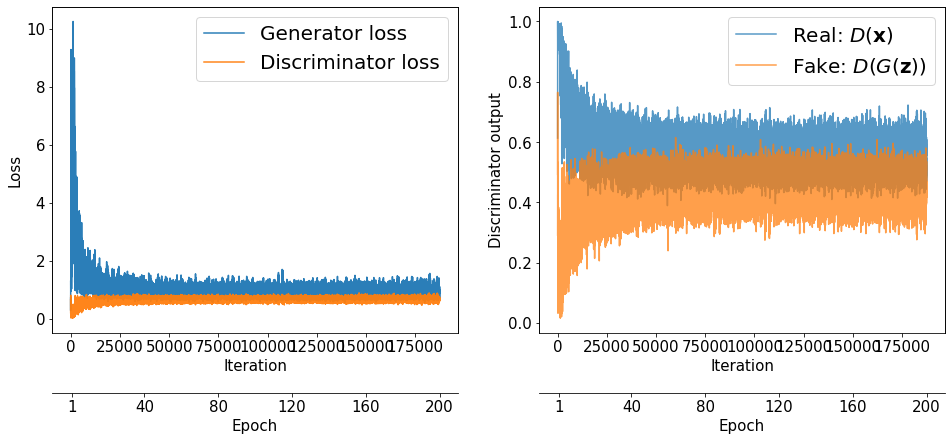

In [27]:
fig = plt.figure(figsize=(16, 6))

## Plotting the losses
ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2.0 for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 201)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 40, 80, 120, 160, 200]
newpos = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

## Plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(*all_d_vals)]
plt.plot(d_vals_real, alpha=0.75, label=r'Real: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)


#plt.savefig('images/ch17-gan-learning-curve.pdf')
plt.show()

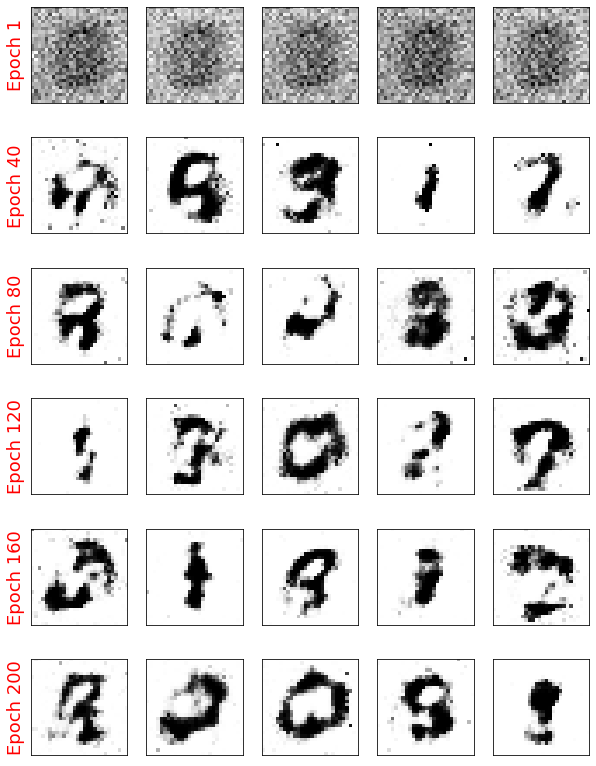

In [28]:
selected_epochs = [1, 40, 80, 120, 160, 200]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
#plt.savefig('images/ch17-vanila-gan-samples.pdf')
plt.show()

